In [1]:
# Autoreload packages in case they change.
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import btk

# "Multi" tutorial

This notebook is intended to showcase the use of BTK is the case where multiple outputs are desired: multiresolution, several measure functions or the use of the `measure_kwargs`. We advise you to follow the intro tutorial before this one if you have not done it already.

### Table of contents

- [Multiresolution](#multiresolution)
- [Multiple measure functions](#multiple_measure_functions)
- [Measure kwargs](#measure_kwargs)

## General structure

When using one of the aforementioned features, the usual results are replaced by dictionaries. The general structure is `results[measure_function][survey]`; the `measure_function` layer exists only for the output of the MeasureGenerator and MetricsGenerator (and is always there), while the `survey` is for all the generators, but only in the case of multiresolution. See the examples below for more details.

## Multiresolution
<a id='multiresolution'></a>
BTK supports generating images in different resolutions, for example in the case of joint analysis between surveys, or for surveys with multiple instruments (e.g. Euclid). To do this, you should provide several Survey objects to the DrawBlendGenerator (in the case of multiple instruments, those should be implemented as different Survey objects anyway). If the surveys have different pixel scales, the images will show the same sky area with the different pixel scales, meaning the images will have a different number of pixels. If you provide a list with only one survey, it will behave as if a single survey was provdided (not as a list).

In [2]:
sampling_function = btk.sampling_functions.DefaultSampling()
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
surveys = btk.survey.get_surveys(["Rubin","HSC"])
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    surveys,
    stamp_size=stamp_size,
    batch_size=5             
)

Once this is done, you can access the data from the different surveys by accessing the dictionaries under each entry of the results.

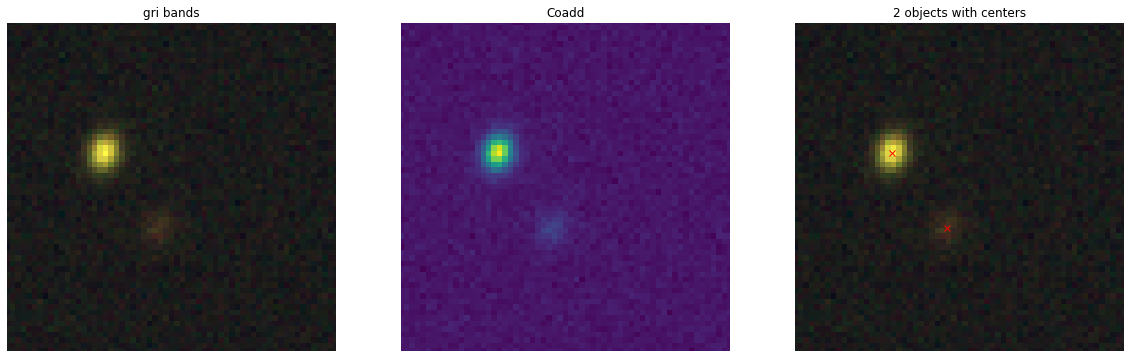

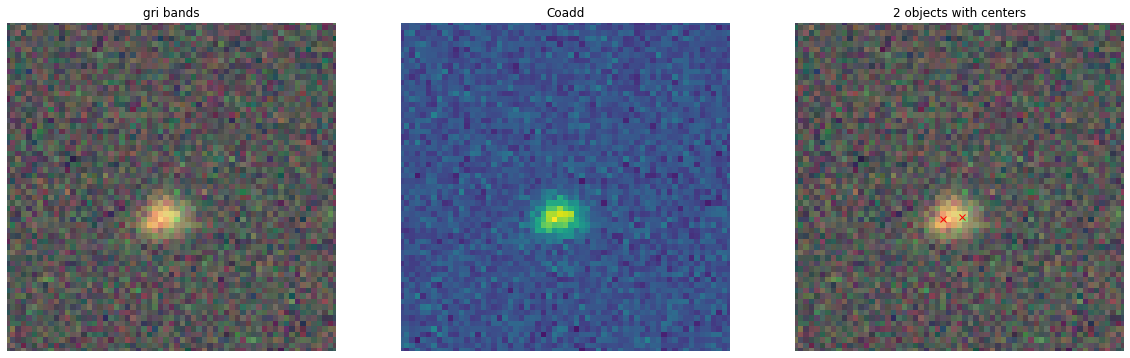

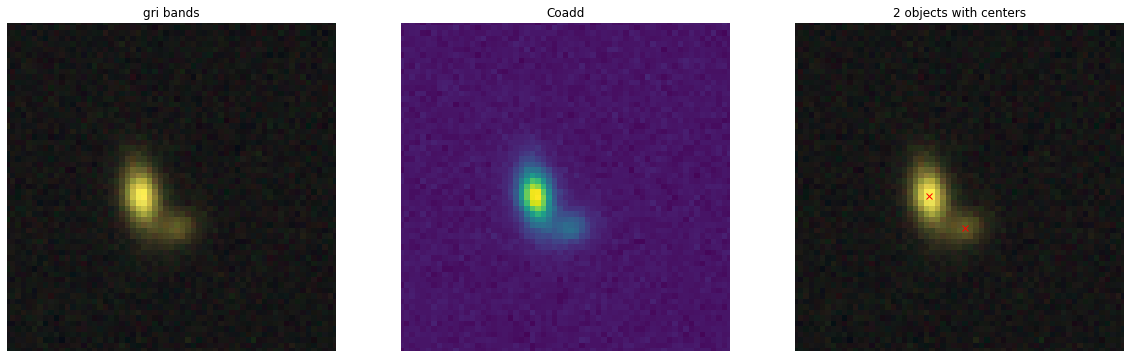

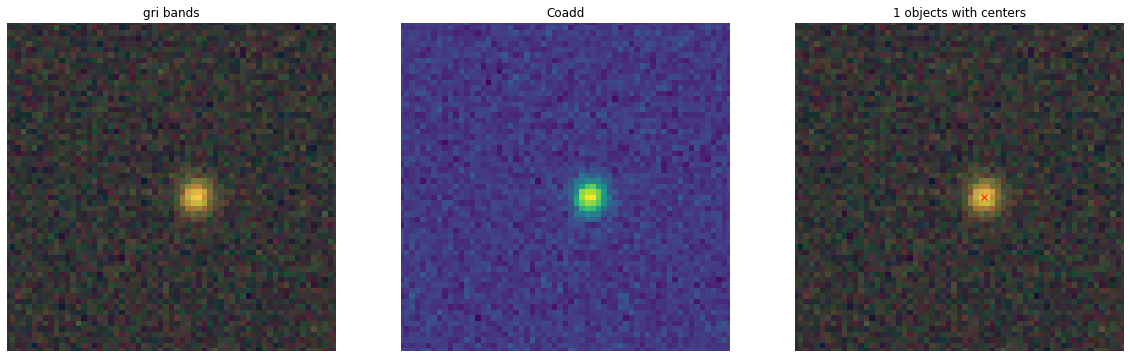

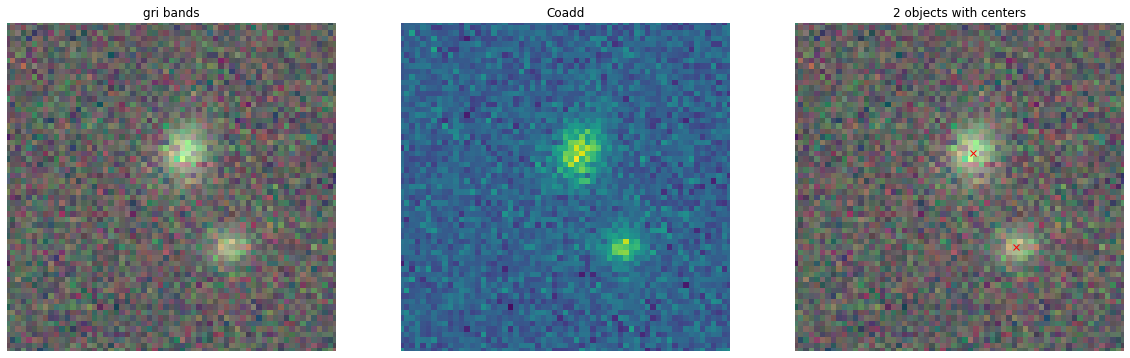

In [3]:
batch = next(draw_blend_generator)
blend_images = batch['blend_images']["Rubin"]
blend_list = batch['blend_list']["Rubin"]
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

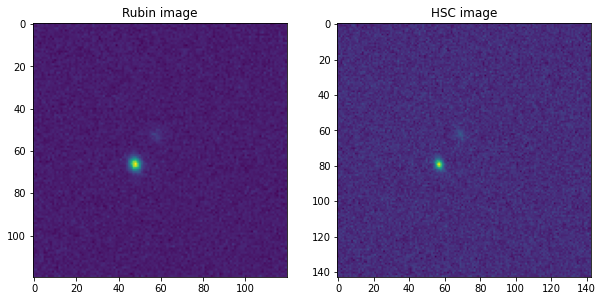

Size of the LSST image : 120 pixels
Size of the HSC image : 143 pixels


In [4]:
#Showing the two images side to side
fig,ax = plt.subplots(1,2,figsize=(10,20))
ax[0].imshow(batch['blend_images']["Rubin"][0,2])
ax[1].imshow(batch['blend_images']["HSC"][0,2])
ax[0].set_title("Rubin image")
ax[1].set_title("HSC image")
plt.show()
print(f"Size of the LSST image : {batch['blend_images']['Rubin'].shape[2]} pixels")
print(f"Size of the HSC image : {batch['blend_images']['HSC'].shape[2]} pixels")

In the same fashion, the outputs of the MeasureGenerator and MetricsGenerator are also modified to be indexed on the surveys.

In [5]:
meas_generator = btk.measure.MeasureGenerator(btk.measure.sep_measure,draw_blend_generator)
metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity},
                                                 meas_band_num=(0,0))
blend_results,measure_results,metrics_results = next(metrics_generator)

In [6]:
survey = "HSC"
print("Results for HSC :")
print(measure_results["catalog"]["sep_measure"][survey])
print(metrics_results["galaxy_summary"]["sep_measure"][survey]["x_peak","y_peak"])

Results for HSC :
[<Table length=1>
          ra                    dec                x_peak           y_peak     
       float64                float64             float64          float64     
---------------------- --------------------- ----------------- ----------------
0.00026888347208294276 0.0005650669720197768 76.79629041620971 83.1810844272233, <Table length=2>
          ra                     dec           ...       y_peak     
       float64                 float64         ...      float64     
---------------------- ----------------------- ... -----------------
0.00040373704481498624 -0.00040700468416850254 ... 62.22624632893209
    359.99996041271595 -0.00017597509881113596 ... 67.20652481603689, <Table length=2>
          ra                    dec           ...       y_peak     
       float64                float64         ...      float64     
---------------------- ---------------------- ... -----------------
0.00018592773958982044 -0.0006498623598712474 ... 56.990991

For plotting the results, you do not need to adapt the `plot_metrics_summary` function, which will work natively with the multiresolution. However, if you want to use the `plot_with_deblended` function, you need to add the survey layer to the results.

In [7]:
btk.plot_utils.plot_metrics_summary(metrics_results,interactive=True)

## Multiple measure functions
<a id='multiple_measure_functions'></a>

In order to compare different algorithms, you may want to input several measure functions so that all measurements are carried on the same images. This can simply be done by providing a list of measure functions instead of one. As for multiresolution, the output will be a dictionary with the same keys as usual, except each entry will contain a dictionary indexed by the names of the measure functions.

In [8]:
sampling_function = btk.sampling_functions.DefaultSampling()
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
survey = btk.survey.get_surveys("Rubin")
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=10
)
meas_generator = btk.measure.MeasureGenerator([btk.measure.sep_measure,btk.measure.basic_measure],
                                              draw_blend_generator)

In [9]:
blend_results, measure_results = next(meas_generator)

Plot with the sep detections


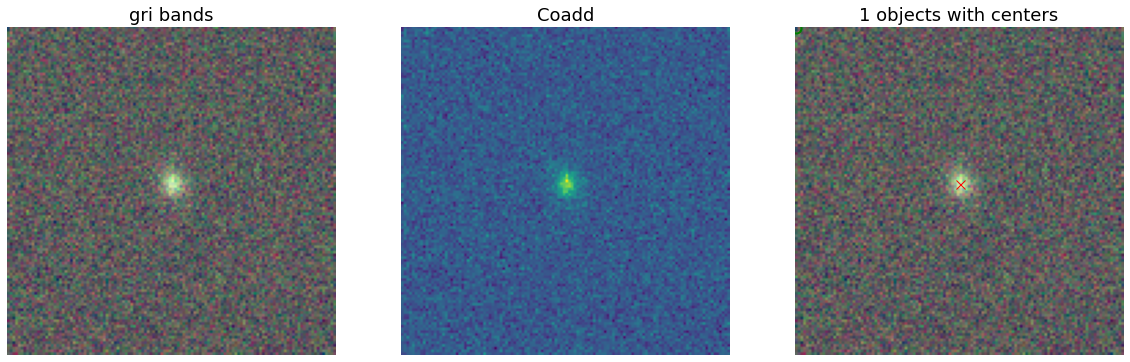

Plot with the photutils detections


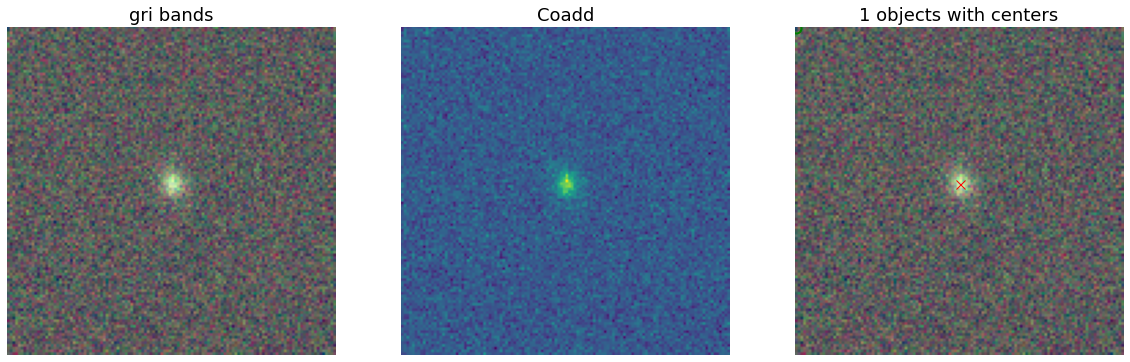

In [10]:
print("Plot with the sep detections")
btk.plot_utils.plot_blends(blend_results["blend_images"][:1],
                           blend_results["blend_list"][:1],
                           measure_results["catalog"]["sep_measure"][:1])
print("Plot with the photutils detections")
btk.plot_utils.plot_blends(blend_results["blend_images"][:1],
                           blend_results["blend_list"][:1],
                           measure_results["catalog"]["basic_measure"][:1])

## Measure kwargs
<a id='measure_kwargs'></a>

You may want to pass some arguments to your measure function; in particular you may want to run your measure function with different parameters, without redefining a new measure function each time. This can be achieved using the `measure_kwargs` argument. It should take the form of a list of dictionaries, whose entries are the name of the arguments. The measure function will be executed one time for each element of the list, using the arguments from that dictionnary. The results will be separated by adding a number at the end of the measure function (e.g. `sep_measure0`, `sep_measure1`...). Please note that if you have provided several measure functions, all of them will receive all the arguments.

In [11]:
sampling_function = btk.sampling_functions.DefaultSampling()
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
survey = btk.survey.get_surveys("Rubin")
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=10
)
measure_kwargs = [{'sigma_noise':1.0},
                  {'sigma_noise':2.0},
                  {'sigma_noise':3.0},
                  {'sigma_noise':5.0}]
meas_generator = btk.measure.MeasureGenerator(btk.measure.sep_measure,
                                              draw_blend_generator,
                                              measure_kwargs=measure_kwargs)

In [12]:
blend_results, measure_results = next(meas_generator)

Plot with the sigma = 1.0 detections


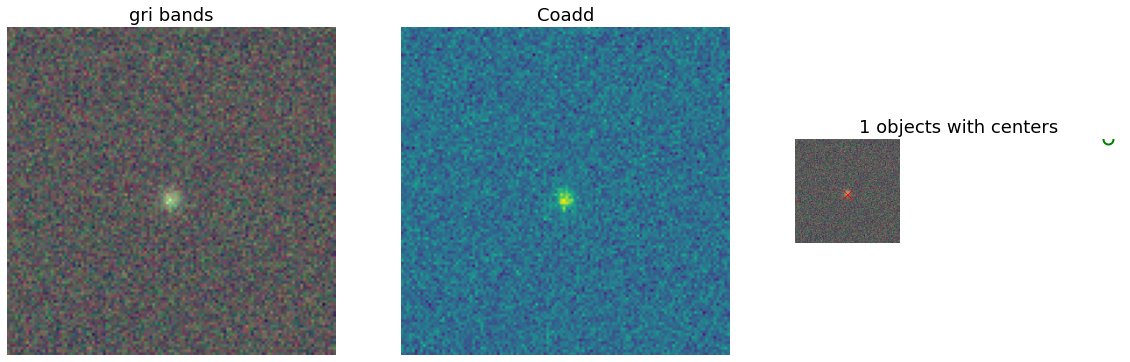

Plot with the sigma = 2.0 detections


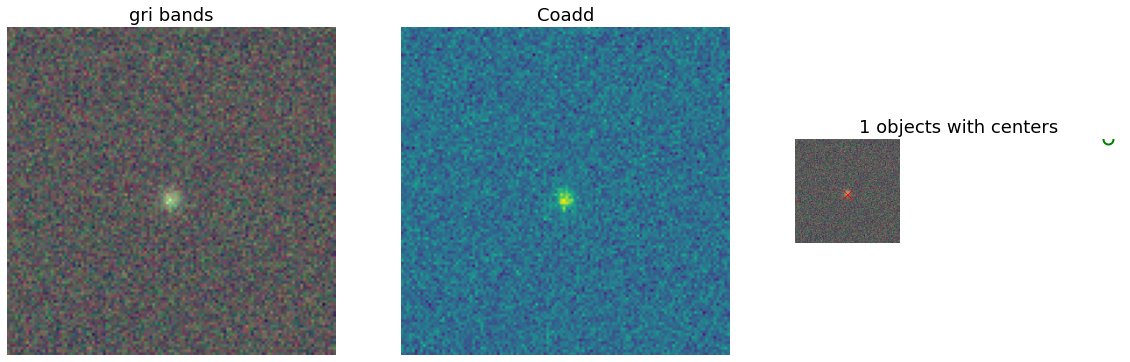

In [13]:
print("Plot with the sigma = 1.0 detections")
btk.plot_utils.plot_blends(blend_results["blend_images"][:1],
                           blend_results["blend_list"][:1],
                           measure_results["catalog"]["sep_measure0"][:1])
print("Plot with the sigma = 2.0 detections")
btk.plot_utils.plot_blends(blend_results["blend_images"][:1],
                           blend_results["blend_list"][:1],
                           measure_results["catalog"]["sep_measure1"][:1])

Using the measure_kwargs also allows you to use the Average Precision metric. It is a more complex metric which evaluates an algorithm which has a modifiable parameter (eg a threshold); you can make the measurements with different thresholds, compute the precision and the recall in every case, and draw the precision-recall curve. When doing so with several different algorithms, the algorithm with the best detection will have a curve "above" the other; this can be quantified by computing the area under the curve, which we call Average Precision.

In BTK, you can use the `btk.metrics.auc` function to compute the average precision:

In [14]:
metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity})
blend_results,meas_results,metrics_results = next(metrics_generator)
average_precision = btk.metrics.auc(metrics_results,
                                    "sep_measure",
                                    len(measure_kwargs))
print("Average precision : ",average_precision)

Average precision :  0.7170868347338935


Please note that this example is not very representative; sep rarely makes any spurious detections, leading to a very high precision for every recall. If you want, you can plot the curve by passing the parameter `plot=True`, and optionally a matplotlib Axes as the argument `ax`.